In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load the CSV data into a DataFrame
results_df = pd.read_csv('../../results/analysis_data_results/grid_search_results/grid_search_results.csv')


In [12]:
# Convert RMSE to numeric, handling missing values (R-Learner RMSE is not applicable)
results_df['best_rmse'] = pd.to_numeric(results_df['best_rmse'], errors='coerce')
results_df['best_emse'] = pd.to_numeric(results_df['best_emse'], errors='coerce')

In [13]:
# Function to plot RMSE for S, T, X-Learners
def plot_rmse(results_df):
    # Filter out R-Learner since it doesn't have RMSE
    filtered_df = results_df[results_df['learner'] != 'R-Learner']
    plt.figure(figsize=(12, 6))
    sns.barplot(data=filtered_df, x='learner', y='best_rmse', hue='model', palette='Set2')
    plt.title('Predictive Performance (RMSE) of Meta-Learners')
    plt.ylabel('RMSE (Lower is Better)')
    plt.xlabel('Meta-Learner')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

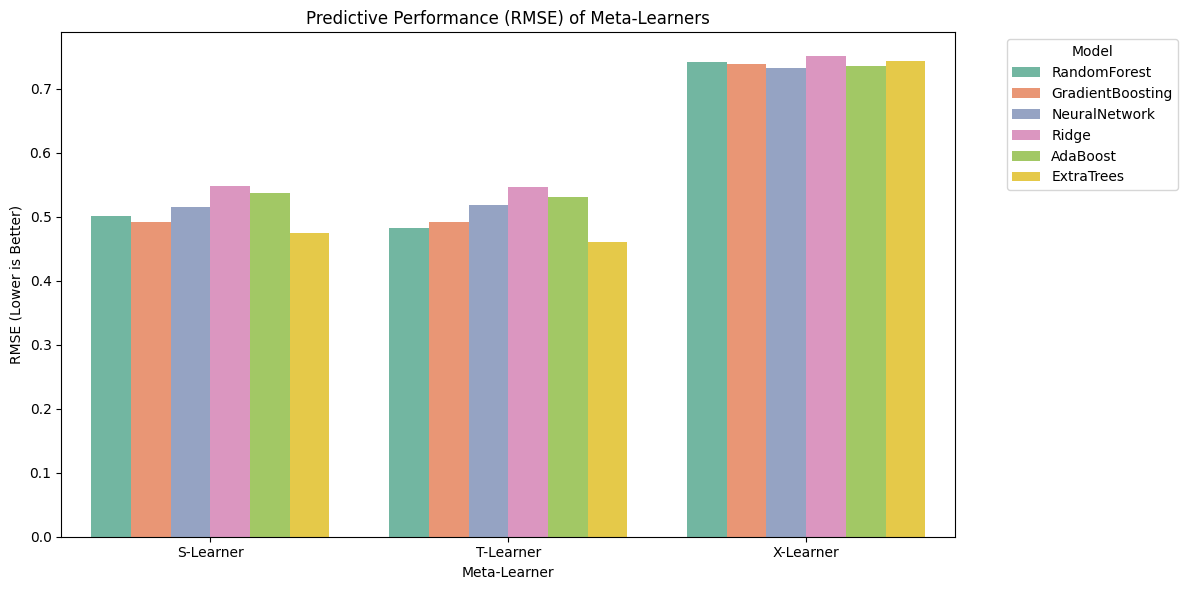

In [14]:
# Visualize RMSE for S, T, X-Learners
plot_rmse(results_df)

In [15]:
# Function to plot EMSE for all meta-learners
def plot_emse(results_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x='learner', y='best_emse', hue='model', palette='Set1')
    plt.title('Variability of CATE Estimates (EMSE) Across Meta-Learners')
    plt.ylabel('EMSE (Lower is Better)')
    plt.xlabel('Meta-Learner')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

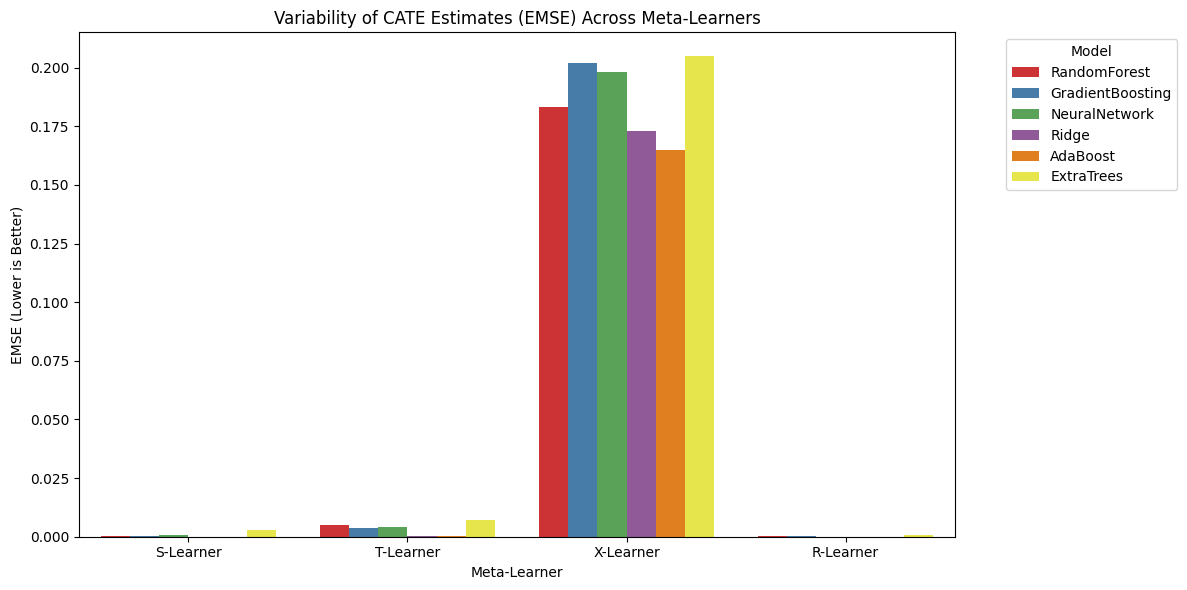

In [16]:
# Visualize EMSE for all meta-learners
plot_emse(results_df)

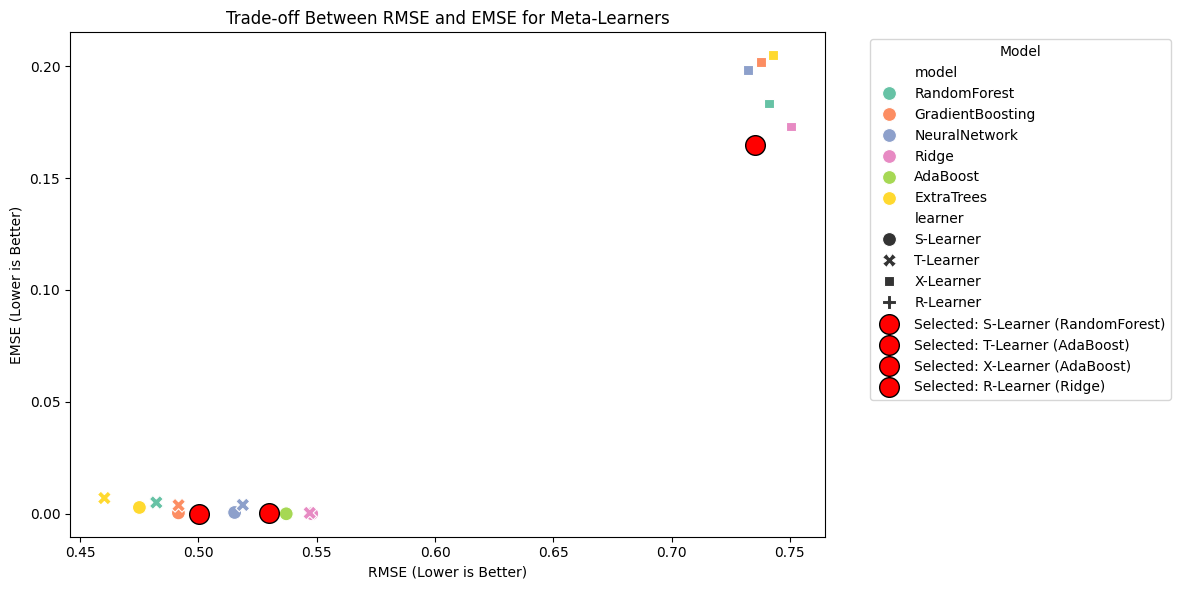

In [17]:
# Function to select models based on RMSE and EMSE
def select_models(results_df):
    tradeoff_models = []

    for learner in results_df['learner'].unique():
        # learner_df = results_df[results_df['learner'] == learner]
        learner_df = results_df[results_df['learner'] == learner].copy()  # Useing .copy() to avoid SettingWithCopyWarning

        
        # Best model based on EMSE
        best_emse_model = learner_df.nsmallest(1, 'best_emse')
        
        # For S, T, X-Learners, calculate tradeoff; for R-Learner, use EMSE
        if learner != 'R-Learner':
            learner_df['normalized_rmse'] = learner_df['best_rmse'] / learner_df['best_rmse'].max()
            learner_df['normalized_emse'] = learner_df['best_emse'] / learner_df['best_emse'].max()
            learner_df['tradeoff_score'] = learner_df['normalized_rmse'] + learner_df['normalized_emse']
            best_tradeoff_model = learner_df.nsmallest(1, 'tradeoff_score')
        else:
            best_tradeoff_model = best_emse_model
        
        tradeoff_models.append(best_tradeoff_model)
    tradeoff_df = pd.concat(tradeoff_models, ignore_index=True)
    
    return tradeoff_df

# Select models
tradeoff_df = select_models(results_df)

# Plotting tradeoff visualization
def plot_tradeoff(results_df, tradeoff_df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=results_df, x='best_rmse', y='best_emse', hue='model', style='learner', palette='Set2', s=100)
    
    # Highlight selected models for tradeoff
    for _, row in tradeoff_df.iterrows():
        plt.scatter(row['best_rmse'], row['best_emse'], color='red', s=200, label=f"Selected: {row['learner']} ({row['model']})", edgecolors='black')
    
    plt.title('Trade-off Between RMSE and EMSE for Meta-Learners')
    plt.xlabel('RMSE (Lower is Better)')
    plt.ylabel('EMSE (Lower is Better)')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_tradeoff(results_df, tradeoff_df)

In [18]:
from tabulate import tabulate

def create_selected_model_table(tradeoff_df):
    """
    Create a better-looking table showing the final selected models and their best parameters for each meta-learner.
    """
    # Extract relevant columns
    selected_models_table = tradeoff_df[['learner', 'model', 'best_params', 'best_rmse', 'best_emse']].copy()
    
    # Rename columns for better readability
    selected_models_table.rename(columns={
        'learner': 'Meta-Learner',
        'model': 'Selected Model',
        'best_params': 'Best Parameters',
        'best_rmse': 'RMSE (Lower is Better)',
        'best_emse': 'EMSE (Lower is Better)'
    }, inplace=True)

    # Convert to a list of dictionaries for tabulate
    table_data = selected_models_table.to_dict(orient='records')

    # Print the table using tabulate
    print(tabulate(
        table_data,
        headers="keys",
        tablefmt="grid",
        numalign="center",
        stralign="center"
    ))

# Create and display the table
create_selected_model_table(tradeoff_df)


+----------------+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+--------------------------+
|  Meta-Learner  |  Selected Model  |                                                                                      Best Parameters                                                                                       |  RMSE (Lower is Better)  |  EMSE (Lower is Better)  |
+================+==================+============================================================================================================================================================================================+==========================+==========================+
|   S-Learner    |   RandomForest   |                                                   {'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 20, 'n_